In [17]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchsummary import summary

import matplotlib.pyplot as plt
import torchvision

bs = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.z_dim = z_dim
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        self.history = {"train_loss": [], "val_loss": []}

        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def reconstruction(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def sampling(self): 
        # assume latent features space ~ N(0, 1)
        z = torch.randn(64, self.z_dim).to(self.device)
        sample = self.decoder(z).cuda()
        #decode
        return sample
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.reconstruction(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [3]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [4]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [18]:
summary(vae, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                    [-1, 2]             514
            Linear-4                    [-1, 2]             514
            Linear-5                  [-1, 256]             768
            Linear-6                  [-1, 512]         131,584
            Linear-7                  [-1, 784]         402,192
Total params: 1,068,820
Trainable params: 1,068,820
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 4.08
Estimated Total Size (MB): 4.10
----------------------------------------------------------------


In [5]:
def train(epoch):
    vae.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()

        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    vae.history["train_loss"].append(train_loss / len(train_loader.dataset))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [6]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    vae.history["val_loss"].append(test_loss)
    
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [7]:
for epoch in range(1, 50):
    train(epoch)
    test()

/home/fusemachines/.cache/pypoetry/virtualenvs/poetry-env-H-6CZZOK-py3.8/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 547.848999
Train Epoch: 1 [12800/60000 (21%)]	Loss: 186.632324
Train Epoch: 1 [25600/60000 (43%)]	Loss: 175.594101
Train Epoch: 1 [38400/60000 (64%)]	Loss: 170.850708
Train Epoch: 1 [51200/60000 (85%)]	Loss: 160.604630
====> Epoch: 1 Average loss: 182.5347
====> Test set loss: 160.9847
Train Epoch: 2 [0/60000 (0%)]	Loss: 157.068924
Train Epoch: 2 [12800/60000 (21%)]	Loss: 155.281662
Train Epoch: 2 [25600/60000 (43%)]	Loss: 149.353271
Train Epoch: 2 [38400/60000 (64%)]	Loss: 158.059174
Train Epoch: 2 [51200/60000 (85%)]	Loss: 154.125000
====> Epoch: 2 Average loss: 157.8155
====> Test set loss: 154.2401
Train Epoch: 3 [0/60000 (0%)]	Loss: 149.169235
Train Epoch: 3 [12800/60000 (21%)]	Loss: 154.660095
Train Epoch: 3 [25600/60000 (43%)]	Loss: 160.063049
Train Epoch: 3 [38400/60000 (64%)]	Loss: 159.880035
Train Epoch: 3 [51200/60000 (85%)]	Loss: 159.505524
====> Epoch: 3 Average loss: 152.6679
====> Test set loss: 150.5397
Train Epoch: 4 [0/60000 (0%)]	L

Train Epoch: 26 [12800/60000 (21%)]	Loss: 137.700806
Train Epoch: 26 [25600/60000 (43%)]	Loss: 136.893158
Train Epoch: 26 [38400/60000 (64%)]	Loss: 134.866348
Train Epoch: 26 [51200/60000 (85%)]	Loss: 136.406036
====> Epoch: 26 Average loss: 137.2590
====> Test set loss: 139.4135
Train Epoch: 27 [0/60000 (0%)]	Loss: 133.966614
Train Epoch: 27 [12800/60000 (21%)]	Loss: 134.577820
Train Epoch: 27 [25600/60000 (43%)]	Loss: 137.838593
Train Epoch: 27 [38400/60000 (64%)]	Loss: 139.639465
Train Epoch: 27 [51200/60000 (85%)]	Loss: 133.416046
====> Epoch: 27 Average loss: 137.2604
====> Test set loss: 138.7910
Train Epoch: 28 [0/60000 (0%)]	Loss: 136.201340
Train Epoch: 28 [12800/60000 (21%)]	Loss: 139.863541
Train Epoch: 28 [25600/60000 (43%)]	Loss: 137.840775
Train Epoch: 28 [38400/60000 (64%)]	Loss: 139.552811
Train Epoch: 28 [51200/60000 (85%)]	Loss: 135.104584
====> Epoch: 28 Average loss: 136.8569
====> Test set loss: 139.0417
Train Epoch: 29 [0/60000 (0%)]	Loss: 144.757614
Train Epoch: 

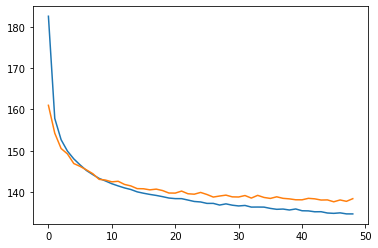

In [8]:
plt.plot(vae.history["train_loss"])
plt.plot(vae.history["val_loss"])

In [9]:
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

In [10]:
input_imgs = get_train_images(32)

In [11]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, mean, var = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs.view(32, 1, 28, 28)], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(20,20))
    plt.title(f"Actual image Vs Reconstructed image")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

/home/fusemachines/.cache/pypoetry/virtualenvs/poetry-env-H-6CZZOK-py3.8/lib/python3.8/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


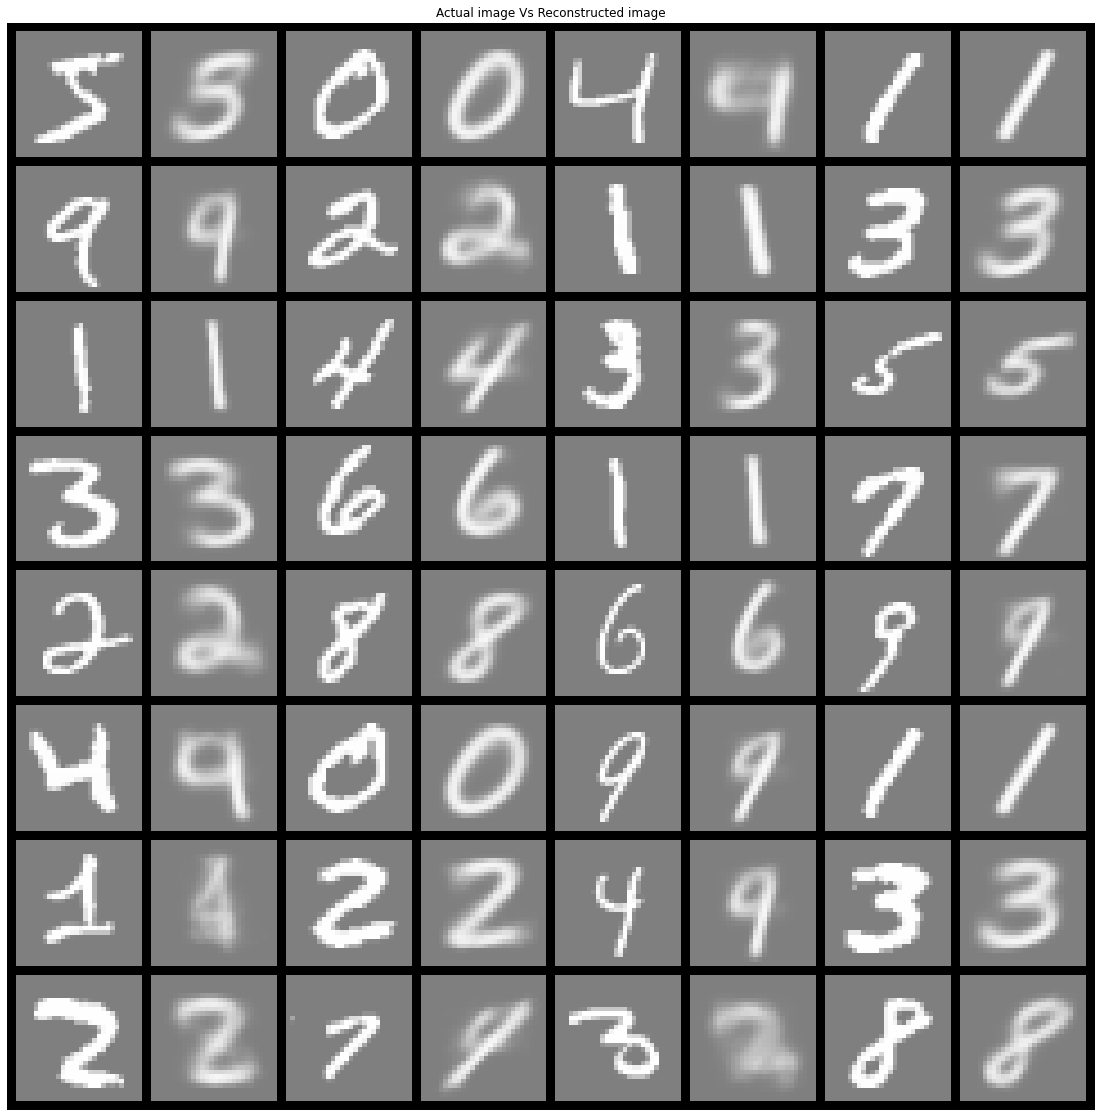

In [12]:
visualize_reconstructions(vae, input_imgs)

In [13]:
sample_images = vae.sampling()

In [14]:
def visualize_sample_reconstructions(input_imgs):
    # Reconstruct images
    input_imgs = input_imgs.view(64, 1, 28, 28).cpu()

    # Plotting
    imgs = torch.stack([input_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(10,10))
    plt.title(f"Sampled image")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

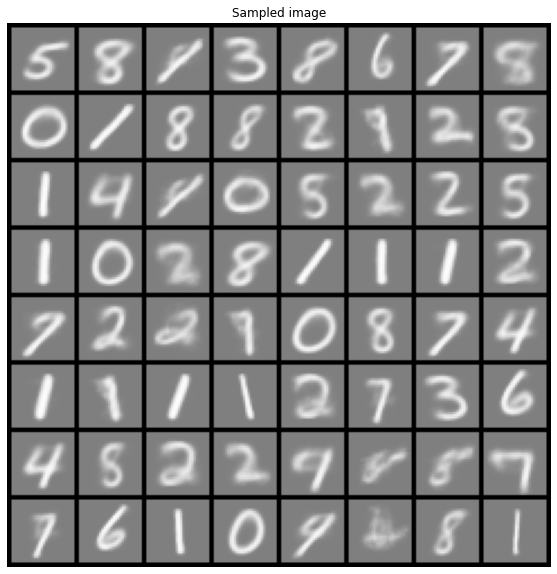

In [15]:
visualize_sample_reconstructions(sample_images)

In [16]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), 'samples/sample_' + '.png')